# Multi-product SARIMA analysis (statsmodels fallback)

Requirements: `numpy`, `pandas`, `statsmodels`, `scikit-learn`, `matplotlib`, `seaborn`.

Note: Install packages in your activated virtual environment (recommended) rather than running installs inline in the notebook.

In [1]:
# Install plotting packages in your environment if missing:
# python -m pip install matplotlib seaborn

In [2]:
# # Install statsmodels into the kernel's Python (runs pip in the same interpreter)
# import sys, subprocess
# subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels"])

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.notebook import tqdm  # Progress bar for notebook

In [4]:
# Load CSV with proper NaN handling
# csv_path = 'consolidated_file_cleaned_v1.csv'
# csv_path = 'sample.csv'
csv_path = 'consolidated_file_cleaned_v1_trimmed_by_product_ids_0pct.csv'
df = pd.read_csv(csv_path, na_values=['', ' ', 'NaN'])

In [5]:
# Clean column headers: remove special chars, whitespace, and rename
def clean_col(col):
    col = re.sub(r'\(.*?\)', '', col)  # Remove anything in parentheses
    col = re.sub(r'[^a-zA-Z0-9_ ]', '', col)  # Remove non-alphanumeric except underscore and space
    col = col.strip().replace(' ', '_').lower()
    # Only rename sold/month(₱) to sold_monthly (actual revenue)
    if col in ['sold_month', 'sold_monthly', 'soldmonth', 'sold/month', 'soldmonth₱', 'sold_month₱', 'sold/month₱']:
        return 'sold_monthly'
    if col == 'soldmonth₱' or col == 'sold_month₱' or col == 'sold/month₱':
        return 'sold_monthly'
    if col == 'time':
        return 'date'
    return col
df.columns = [clean_col(c) for c in df.columns]
print('Columns after cleaning:', df.columns.tolist())

Columns after cleaning: ['product', 'date', 'avgsku_price', 'soldday', 'revenueday', 'soldm', 'product_sales_rate', 'price', 'sku', 'sold', 'sold_monthly', 'revenuemonth', 'new_ratings', 'ratings', 'ratings_rate', 'likes', 'rating_star', 'new_likes', 'id', 'toplevel_category', 'seller_from', 'listing_time', 'active_months', 'suitable_for_seasonal_analysis']


In [6]:
# Detect product ID column robustly
product_id_col = None
for col in df.columns:
    if col in ['product_id', 'id', 'productid', 'prod_id', 'prodid']:
        product_id_col = col
        break
if not product_id_col:
    # Fallback: use 'id' if present, else use 'product' (not ideal, but better than nothing)
    if 'id' in df.columns:
        product_id_col = 'id'
    elif 'product' in df.columns:
        product_id_col = 'product'
if not product_id_col:
    pass  # No product ID column found
else:
    # SARIMA analysis loop (robust univariate input)
    results_dict = {}
    product_groups = list(df.groupby(product_id_col))
    for product_id, group in tqdm(product_groups, desc='Fitting SARIMA models'):
        # Use only 'sold_monthly' column (actual revenue)
        sales_col = 'sold_monthly'
        if sales_col not in group.columns:
            continue
        # If there are duplicate columns, select all occurrences
        sales_cols = [c for c in group.columns if c == sales_col]
        sales = group[['date'] + sales_cols].copy()
        # If multiple 'sold_monthly' columns, keep only the first for conversion
        if len(sales_cols) > 1:
            sales[sales_col] = pd.to_numeric(sales[sales_cols[0]], errors='coerce').fillna(0)
        else:
            sales[sales_col] = pd.to_numeric(sales[sales_col], errors='coerce').fillna(0)
        # Drop any extra duplicate columns
        sales = sales.loc[:, ~sales.columns.duplicated()]
        # Convert date column to datetime and set as index
        sales['date'] = pd.to_datetime(sales['date'])
        # Aggregate by date to ensure unique index
        sales = sales.groupby('date').sum()
        # Fill missing months with zero sales for continuity
        all_months = pd.date_range(start=sales.index.min(), end=sales.index.max(), freq='MS')
        sales = sales.reindex(all_months, fill_value=0)
        # Select the sales column as a Series (univariate)
        monthly_sales = sales[sales_col]
        # Check for at least 12 consecutive months with nonzero sales
        nonzero_months = monthly_sales[monthly_sales > 0]
        if len(nonzero_months) < 12:
            continue
        try:
            model = SARIMAX(monthly_sales, order=(1,1,1), seasonal_order=(1,1,1,12))
            results = model.fit(disp=False)
            results_dict[product_id] = results
        except Exception as e:
            pass

Fitting SARIMA models:   0%|          | 0/83 [00:00<?, ?it/s]

c:\Users\Ven\Documents\Coding\pambihira\CRAZY\poop\ShopeeAnalysis_Amalgam\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Ven\Documents\Coding\pambihira\CRAZY\poop\ShopeeAnalysis_Amalgam\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Ven\Documents\Coding\pambihira\CRAZY\poop\ShopeeAnalysis_Amalgam\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Ven\Documents\Coding\pambihira\CRAZY\poop\Shope

## Visualize SARIMA Results for a Selected Product

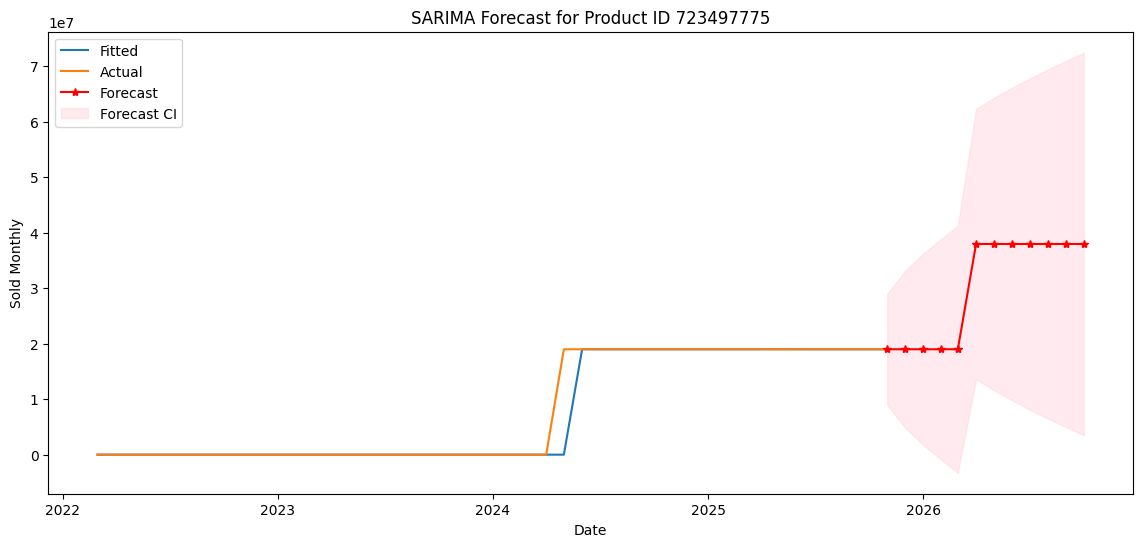

In [8]:
# Change index to visualize other products
selected_pid = list(results_dict.keys())[0] if results_dict else None
if selected_pid:
    res = results_dict[selected_pid]
    plt.figure(figsize=(14,6))
    # Plot the fitted values (in-sample prediction)
    plt.plot(res.fittedvalues.index, res.fittedvalues, label='Fitted')
    # Plot the actuals (if available)
    if hasattr(res.model.data, 'endog') and hasattr(res.model.data, 'row_labels'):
        plt.plot(res.model.data.row_labels, res.model.data.endog, label='Actual')
    # Forecast the next 12 months
    forecast = res.get_forecast(steps=12)
    forecast_index = pd.date_range(res.data.dates[-1], periods=12, freq='MS')
    plt.plot(forecast_index, forecast.predicted_mean, 'r*-', label='Forecast')
    conf_int = forecast.conf_int()
    plt.fill_between(forecast_index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3, label='Forecast CI')
    plt.legend()
    plt.title(f'SARIMA Forecast for Product ID {selected_pid}')
    plt.ylabel('Sold Monthly')
    plt.xlabel('Date')
    plt.show()
else:
    print('No products with valid SARIMA results.')

## Summary Table of RMSE and MAPE for All Products

In [10]:
# Example: Summary table of AIC for all products (since RMSE and MAPE are not available by default)
import pandas as pd
summary = pd.DataFrame([
    {'id': pid, 'aic': res.aic}
    for pid, res in results_dict.items()
])
summary.sort_values('aic').head(10)  # Show top 10 products by AIC

,id,aic
21,13032304534,10.000000
5,3544503750,584.915294
24,16003323508,643.470057
38,22206135422,667.501139
25,16471337632,675.662892
16,9555572214,678.789728
51,24763604980,679.118523
34,20243533839,682.097518
26,16631089688,685.951402
18,11225744521,687.515600


In [11]:
# --- Peak Demand Months and Top-Selling Products Analysis ---
# Forecast next 12 months for all products and store results
forecast_horizon = 12
product_forecasts = {}  # {product_id: pd.Series of forecasted sales}
for pid, res in results_dict.items():
    forecast = res.get_forecast(steps=forecast_horizon)
    forecast_index = pd.date_range(res.data.dates[-1], periods=forecast_horizon, freq='MS')
    product_forecasts[pid] = pd.Series(forecast.predicted_mean.values, index=forecast_index)

# 1. Peak demand months per product
peak_months_per_product = {}
for pid, forecast in product_forecasts.items():
    # Find the month(s) with the highest forecasted sales
    max_val = forecast.max()
    peak_months = forecast[forecast == max_val].index.strftime('%Y-%m').tolist()
    peak_months_per_product[pid] = peak_months

peak_months_df = pd.DataFrame([
    {'product_id': pid, 'peak_months': ', '.join(months)}
    for pid, months in peak_months_per_product.items()
])
print('Peak demand months per product:')
display(peak_months_df.head())

# 2. Top-selling products for a given month
input_month = '2026-01'  # Change this to the month you want to analyze (format: YYYY-MM)
top_products = []
for pid, forecast in product_forecasts.items():
    # Find forecast for the input month
    val = forecast.get(pd.to_datetime(input_month), None)
    if val is not None:
        top_products.append({'product_id': pid, 'forecasted_sales': val})
top_products_df = pd.DataFrame(top_products).sort_values('forecasted_sales', ascending=False)
print(f'Top-selling products for {input_month}:')
display(top_products_df.head(10))  # Show top 10 products for the selected month

# 3. Input a product ID to see its forecasted peak months and monthly forecast
input_product_id = 23943860856  # Change this to the product ID you want to analyze
if input_product_id in product_forecasts:
    forecast = product_forecasts[input_product_id]
    print(f'Forecast for product {input_product_id}:')
    display(forecast)
    max_val = forecast.max()
    peak_months = forecast[forecast == max_val].index.strftime('%Y-%m').tolist()
    print(f'Peak demand month(s): {", ".join(peak_months)}')
else:
    print('Product ID not found in forecasts.')

Peak demand months per product:


,product_id,peak_months
0,723497775,"2026-04, 2026-05, 2026-06, 2026-07, 2026-08, 2..."
1,1203013267,2026-02
2,1980004362,2026-02
3,2205898189,2026-07
4,3128534484,2026-07


Top-selling products for 2026-01:


,product_id,forecasted_sales
56,29703950339,3.688799e+07
55,28001723500,3.117505e+07
0,723497775,1.899217e+07
35,20246220530,1.424820e+07
40,22515917974,5.447396e+06
47,23740537154,3.803274e+06
49,23943860856,3.445181e+06
33,19879460153,3.229732e+06
31,19600631077,1.906092e+06
6,4106120823,1.136001e+06


Forecast for product 23943860856:


2025-11-01    3.445181e+06
2025-12-01    3.445181e+06
2026-01-01    3.445181e+06
2026-02-01    3.445181e+06
2026-03-01    3.445181e+06
2026-04-01    3.445181e+06
2026-05-01    3.445181e+06
2026-06-01    3.445181e+06
2026-07-01    3.445181e+06
2026-08-01    6.889665e+06
2026-09-01    6.889665e+06
2026-10-01    6.889665e+06
Freq: MS, dtype: float64

Peak demand month(s): 2026-09, 2026-10


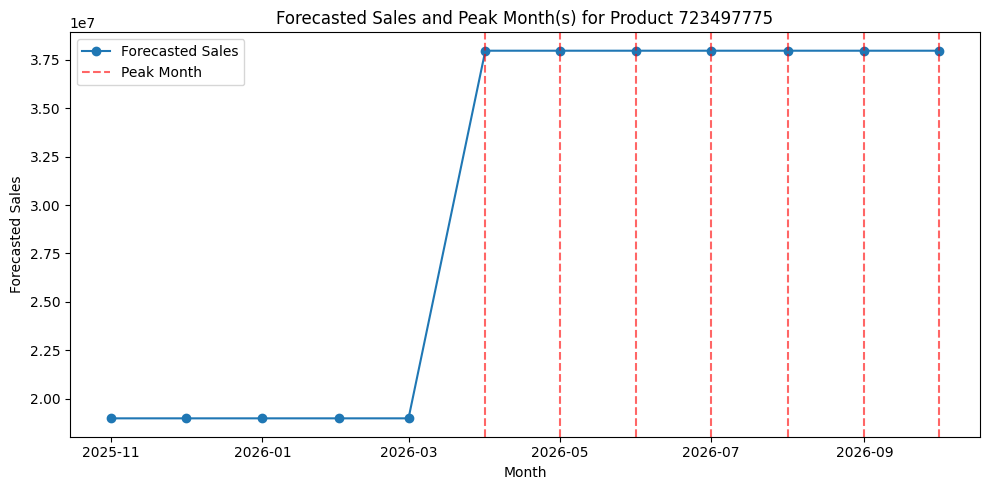

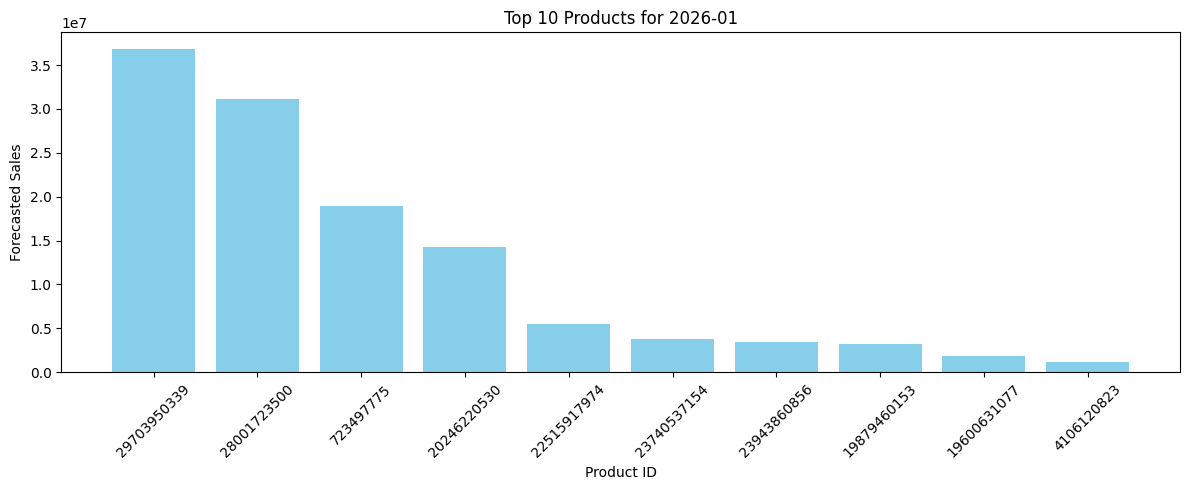

In [12]:
# --- Visualization for Peak Demand and Top Products ---
import matplotlib.pyplot as plt

# 1. Visualize peak demand months for a selected product
selected_pid = list(product_forecasts.keys())[0] if product_forecasts else None  # Change as needed
if selected_pid:
    forecast = product_forecasts[selected_pid]
    plt.figure(figsize=(10, 5))
    plt.plot(forecast.index, forecast.values, marker='o', label='Forecasted Sales')
    max_val = forecast.max()
    peak_months = forecast[forecast == max_val].index
    for peak in peak_months:
        plt.axvline(peak, color='red', linestyle='--', alpha=0.6, label='Peak Month' if peak == peak_months[0] else None)
    plt.title(f'Forecasted Sales and Peak Month(s) for Product {selected_pid}')
    plt.xlabel('Month')
    plt.ylabel('Forecasted Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('No product forecasts available for visualization.')

# 2. Visualize top-selling products for the selected month
if not top_products_df.empty:
    plt.figure(figsize=(12, 5))
    plt.bar(top_products_df['product_id'].astype(str)[:10], top_products_df['forecasted_sales'][:10], color='skyblue')
    plt.title(f'Top 10 Products for {input_month}')
    plt.xlabel('Product ID')
    plt.ylabel('Forecasted Sales')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('No top products data available for visualization.')